## (Word2)Vec-FarmPredict
```Michael Yeung, UROP2100F, Apr 2022```

### Setup

In [1]:
# set paths for input (retrieve raw data) and output (store intermediate and final results)
DATA_PATH = './data/'; OUTPUT_PATH = './output_Word2Vec-FarmPredict/'

In [2]:
from IPython.display import clear_output
import tarfile

In [3]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt
import datetime as dt; from collections import Counter; import torch; import re; import sys
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from scipy.linalg import svd; from scipy.stats import pearsonr, spearmanr
from gensim.models import KeyedVectors
import warnings; warnings.filterwarnings("ignore")
print('** DEVICE **')
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.'); device = torch.device("cpu")
print('\n** PATHS **\nInput:\t%s\nOutput:\t%s' % (DATA_PATH, OUTPUT_PATH))

** DEVICE **
There are 7 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090

** PATHS **
Input:	./data/
Output:	./output_Word2Vec-FarmPredict/


### Helper Functions

In [4]:
# remove non-AV (adj. & v.) string elements of list input
# variant strip POS, remove 'a'/'v' char at the end
def filter_av_strip_pos(words):
    av_words = []
    for s in words:
        pos = str(re.findall(r'[A-z]+', s))[2:-2]
        if pos in ['a','v']:
            av_words.append(s[:-1])
    return av_words

In [5]:
# given a list of tuples of 2 elements (real part and imaginary part),
# return the real part if imaginary part is 0, else return 0
def extract_real(cplx):
    real_part = []
    for e in cplx:
        if e[1] != 0:
            real_part.append(0)
        else:
            real_part.append(e[0])
    return torch.tensor(real_part).type(torch.float32)

In [6]:
# transform a list of strings (vocabs) into a list (vector) of embedding average
def strs2vec(strs,embed,dim=100):
    count = 0
    vec = np.zeros(100)
    for s in strs:
        try:
            vec += embed[s]
            count += 1
        except:
            pass
    if count != 0:
        vec /= count
    return list(vec)

### Grid Search

In [17]:
def w2vFarmPredictGridSearch_kFoldCV(training_data,k=5,serial='_',skip_folds=None):
    kf = KFold(n_splits=k,shuffle=True,random_state=1)
    for fold, (train2_index, valid_index) in enumerate(kf.split(training_data.index)):
        if skip_folds is not None:
            if fold in skip_folds: continue
        print('*** Fold {} ***'.format(fold))
        summary_df,train2_ys,valid_ys\
        = w2vFarmPredictGridSearch(training_data.iloc[train2_index],\
                                   training_data.iloc[valid_index],\
                                   current_fold=fold)
        summary_df.to_parquet(OUTPUT_PATH+'w2v-farm_gs_{}_summary_fold-{}.parquet.gzip'.format(serial,fold))
        train2_ys.to_parquet(OUTPUT_PATH+'w2v-farm_gs_{}_train2_ys_fold-{}.parquet.gzip'.format(serial,fold))
        valid_ys.to_parquet(OUTPUT_PATH+'w2v-farm_gs_{}_valid_ys_fold-{}.parquet.gzip'.format(serial,fold))
        print('Fold {} complete. Files exported to {}'.format(fold,OUTPUT_PATH))
    return

In [24]:
def w2vFarmPredictGridSearch(data_train2_original, data_valid_original,current_fold=None):
    
    # store tensors on 1 (or 2) GPU devices (to aviod lack of memory)
    DEVICE_1 = 'cuda:0'
    DEVICE_2 = 'cuda:1'
    
    # HYPER-PARAMETERS
    NUM_FEATURES = 100
    HYPER_EIGENVAL_PCT = [0.01,0.05,0.1] # fraction of eigenvalues used
    HYPER_IDO_MIN_CORR = [0.0005,0.001,0.005] # min. corr. between idosyncratic components & label
    HYPER_LASSO_LAMBDA = [0,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005] # lambda of the LASSO regression
    
    columns = ['FOLD','HYPER_N','HYPER_E','HYPER_I','HYPER_L','VAR_EXP','LEN_IDO',\
               'TRN_P','TRN_S','TRN_RMSE','VAL_P','VAL_S','VAL_RMSE']

    print('{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}'.format(*columns))
    
    train2_ys = pd.DataFrame(data_train2_original['specret_2d'])
    valid_ys = pd.DataFrame(data_valid_original['specret_2d'])
    summary_df = pd.DataFrame(columns=columns)
    
    data_train2 = data_train2_original.copy(); data_valid = data_valid_original.copy()
    
    # prepare tensors on GPU
    X_train = torch.tensor(np.stack(data_train2.word_vec.values)).type(torch.float32).cuda(device=DEVICE_1)
    y_train = torch.tensor(np.array(data_train2.specret_2d)).type(torch.float32).cuda(device=DEVICE_1)
    X_valid = torch.tensor(np.stack(data_valid.word_vec.values)).type(torch.float32).cuda(device=DEVICE_2)
    y_valid = torch.tensor(np.array(data_valid.specret_2d)).type(torch.float32).cuda(device=DEVICE_2)

    # compute eigens of XTX
    eigenvals_xtx, eigenvecs_xtx = torch.eig((X_train.T@X_train).cpu(), eigenvectors=True)

    for EIGENVAL_PCT in HYPER_EIGENVAL_PCT:
        num_eigenval = int(NUM_FEATURES*(EIGENVAL_PCT))

        # extract largest k real eigenvalues and their eigenvectors (of XXT)
        eigenvals_real = extract_real(eigenvals_xtx)
        eigenvals_df = pd.Series(eigenvals_real).sort_values(ascending=False)
        variance_explained = eigenvals_df[:num_eigenval].sum()/eigenvals_df.sum()
        eigenvals_topk = torch.topk(eigenvals_real,num_eigenval).indices
        XV = torch.nn.functional.normalize((X_train@eigenvecs_xtx.cuda(device=DEVICE_1)).T,p=2).T[:,eigenvals_topk]

        # compute/construct F_hat, B_hat, U_hat, BTB, and BTB inverse
        F_hat = XV*(X_train.shape[0])**0.5
        B_hat = X_train.T@F_hat.cuda(device=DEVICE_1)/(X_train.shape[0])
        U_hat = X_train - F_hat@B_hat.T
        BTB = torch.tensor(np.diag(torch.topk(extract_real(eigenvals_xtx),num_eigenval).values))/len(X_train)
        BTB_inv = torch.linalg.inv(BTB).cuda(device=DEVICE_1)

        # compute f_new and u_new for train2 and valid data
        f_new_train = (BTB_inv@B_hat.T)@X_train.T.type(torch.float32)
        f_new_valid = (BTB_inv.cuda(device=DEVICE_2)@B_hat.cuda(device=DEVICE_2).T)@X_valid.T.type(torch.float32)
        u_new_train = X_train.T - B_hat@f_new_train
        u_new_valid = X_valid.T - B_hat.cuda(device=DEVICE_2)@f_new_valid.cuda(device=DEVICE_2)

        # OLS regression
        reg1 = LinearRegression().fit(F_hat.cpu(), y_train.cpu())
        y_hat = reg1.predict(F_hat.cpu())
        a_hat = reg1.intercept_; b_hat = torch.tensor(reg1.coef_).cuda(device=DEVICE_1)
        y_residual = y_train - torch.tensor(y_hat).cuda(device=DEVICE_1)

        # correlation between U_hat and label
        corrs = [pearsonr(U_hat.T[j].cpu(), y_train.cpu())[0] for j in range(len(U_hat.T))]
        corrs = [0 if x != x else abs(x) for x in corrs]

        # find the idiosyncratic components satisfying minimum correlation
        for IDO_MIN_CORR in HYPER_IDO_MIN_CORR:
            df = pd.DataFrame(corrs,columns=['corr'])
            df['isCharged'] = df['corr'].map(lambda x: abs(x)>IDO_MIN_CORR)
            charged_index = list(df[df.isCharged].index)
            U_hat_S_hat = U_hat.T[charged_index].T

            # LASSO regression
            for LASSO_LAMBDA in HYPER_LASSO_LAMBDA:
                reg2 = Lasso(alpha=LASSO_LAMBDA)
                reg2.fit(U_hat_S_hat.cpu(),y_residual.cpu())
                beta_hat = torch.tensor(reg2.coef_).cuda(device=DEVICE_1)
                beta_nonzero_len = torch.count_nonzero(beta_hat)

                # validation
                y_pred_train = a_hat + b_hat@f_new_train \
                + beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]
                y_pred_valid = a_hat + b_hat.cuda(device=DEVICE_2)@f_new_valid \
                + beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_valid.type(torch.float32)[charged_index]

                # store results
                SPECS = (NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA)
                identifier = 'w2v-farm_n{}_e{}_i{}_l{}'.format(*SPECS)
                y_pred_train_series = pd.Series(y_pred_train.cpu(),name=identifier,index=train2_ys.index)
                y_pred_valid_series = pd.Series(y_pred_valid.cpu(),name=identifier,index=valid_ys.index)

                # two variables storing y_pred's
                train2_ys = pd.concat([train2_ys,y_pred_train_series],axis=1) # all predicted sentiment (train)
                valid_ys = pd.concat([valid_ys,y_pred_valid_series],axis=1) # all predicted sentiment (valid)

                train_pearson = round(pearsonr(train2_ys['specret_2d'],train2_ys[identifier])[0],6)
                train_spearman = round(spearmanr(train2_ys['specret_2d'],train2_ys[identifier])[0],6)
                train_rmse = round((((train2_ys['specret_2d'] - train2_ys[identifier])**2).mean())**0.5,6)

                valid_pearson = round(pearsonr(valid_ys['specret_2d'],valid_ys[identifier])[0],6)
                valid_spearman = round(spearmanr(valid_ys['specret_2d'],valid_ys[identifier])[0],6)
                valid_rmse = round((((valid_ys['specret_2d'] - valid_ys[identifier])**2).mean())**0.5,6)

                stats = (float(str(variance_explained)[:6]),str(int(beta_nonzero_len))+'/'+str(len(charged_index)))
                performance = (train_pearson,train_spearman,train_rmse,valid_pearson,valid_spearman,valid_rmse)
                print('{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}'\
                      .format(current_fold,*SPECS,*stats,*performance))

                # summary_df storing correlations and rmse
                new_row = pd.DataFrame([[current_fold,*SPECS,*stats,*performance]],columns=columns)
                summary_df = pd.concat([summary_df,new_row],ignore_index=True)
                
    # manually release GPU memory (may not work)
    del X_train, y_train, X_valid, y_valid, XV, F_hat, B_hat, U_hat, BTB, BTB_inv
    del f_new_train, f_new_valid, u_new_train, u_new_valid
    return summary_df, train2_ys, valid_ys

## Main

### Preprocessing

In [7]:
WORD_VEC_FILE = 'tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'
wv_from_text = KeyedVectors.load_word2vec_format(DATA_PATH+WORD_VEC_FILE, binary=False)

In [16]:
data = pd.read_parquet(DATA_PATH+'preprocessed_data_1.parquet.gzip')
data.date = data.date.map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
data['word_vec'] = data.jieba_content.map(filter_av_strip_pos).map(lambda x: strs2vec(x,wv_from_text,dim=100))
data = data.drop(columns=['jieba_content'])
data_train = data.loc[data.date<dt.datetime(2015,1,1)]
data_test = data.loc[data.date>=dt.datetime(2015,1,1)]
data_train.shape, data_test.shape

((180353, 7), (292340, 7))

### k-Fold CV GS

Note: If the GPU memory cannot be released, restart the kernal after every fold.<br>
Skip previous fold(s), e.g. to resume from fold ```m```, ```skip_folds=[0,1,2,...,m-1]```

In [25]:
# the results df is exported continuingly and can be monitored
# args: training data, num folds, serial (a name for this CV, used for naming files)
# use skip_folds to RESUME partially done CV (set the kwarg to skip some folds already done, in a list of int)
# When starting a CV for all folds, set kwarg skip_folds to None (or remove the kwarg)
%time w2vFarmPredictGridSearch_kFoldCV(data_train.copy(),k=5,serial='20220420_tencent',\
                                       skip_folds=None) # RESUME a partially done CV
#FOLD  HYPER_N  HYPER_E  HYPER_I  HYPER_L  VAR_EXP  LEN_IDO    TRN_P    TRN_S TRN_RMSE    VAL_P    VAL_S VAL_RMSE

*** Fold 0 ***
     FOLD  HYPER_N  HYPER_E  HYPER_I  HYPER_L  VAR_EXP  LEN_IDO    TRN_P    TRN_S TRN_RMSE    VAL_P    VAL_S VAL_RMSE
        0      100     0.01   0.0005        0    0.935    99/99 0.099434 0.151009 0.076439  0.06918 0.149213 0.161587
        0      100     0.01   0.0005    5e-06    0.935    64/99 0.097255 0.150166 0.076455 0.066368 0.148978 0.161621
        0      100     0.01   0.0005    1e-05    0.935    55/99 0.094691 0.147408 0.076474 0.064173 0.146509 0.161645
        0      100     0.01   0.0005    5e-05    0.935    10/99 0.079674 0.123507 0.076575  0.05479 0.129057 0.161732
        0      100     0.01   0.0005   0.0001    0.935     3/99 0.073383 0.113917 0.076615 0.051655 0.121398 0.161765
        0      100     0.01   0.0005   0.0005    0.935     0/99 0.026458 0.080342 0.076792 0.018178 0.090132 0.161923
        0      100     0.01   0.0005    0.001    0.935     0/99 0.026458 0.080342 0.076792 0.018178 0.090132 0.161923
        0      100     0.01   0.0005    0

### Interpret k-Fold CV GS Results

In [32]:
serial = '20220420_tencent'
num_folds = 5

cv_results = pd.read_parquet(OUTPUT_PATH+'w2v-farm_gs_{}_summary_fold-0.parquet.gzip'.format(serial))
for fold in range(1,num_folds):
    cv_results = pd.concat([cv_results,pd.read_parquet(OUTPUT_PATH+'w2v-farm_gs_{}_summary_fold-{}.parquet.gzip'\
                                                       .format(serial,fold))],axis=0)
cv_results

,FOLD,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
0,0,100,0.01,0.0005,0.000000,0.9350,99/99,0.099434,0.151009,0.076439,0.069180,0.149213,0.161587
1,0,100,0.01,0.0005,0.000005,0.9350,64/99,0.097255,0.150166,0.076455,0.066368,0.148978,0.161621
2,0,100,0.01,0.0005,0.000010,0.9350,55/99,0.094691,0.147408,0.076474,0.064173,0.146509,0.161645
3,0,100,0.01,0.0005,0.000050,0.9350,10/99,0.079674,0.123507,0.076575,0.054790,0.129057,0.161732
4,0,100,0.01,0.0005,0.000100,0.9350,3/99,0.073383,0.113917,0.076615,0.051655,0.121398,0.161765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4,100,0.10,0.0050,0.000050,0.9728,4/41,0.069324,0.139844,0.109357,0.152854,0.138242,0.041560
68,4,100,0.10,0.0050,0.000100,0.9728,0/41,0.067320,0.137656,0.109371,0.149321,0.135376,0.041584
69,4,100,0.10,0.0050,0.000500,0.9728,0/41,0.067320,0.137656,0.109371,0.149321,0.135376,0.041584
70,4,100,0.10,0.0050,0.001000,0.9728,0/41,0.067320,0.137656,0.109371,0.149321,0.135376,0.041584


In [33]:
cv_results_folds_mean = cv_results.groupby(by=['HYPER_N','HYPER_E','HYPER_I','HYPER_L'])\
[['TRN_P','TRN_S','VAL_P','VAL_S','TRN_RMSE','VAL_RMSE','VAR_EXP']].mean().reset_index()
cv_results_folds_mean.sort_values(by='VAL_S',ascending=False).head()

,HYPER_N,HYPER_E,HYPER_I,HYPER_L,TRN_P,TRN_S,VAL_P,VAL_S,TRN_RMSE,VAL_RMSE,VAR_EXP
25,100,0.05,0.0005,0.000005,0.087494,0.147098,0.111507,0.145033,0.098730,0.088660,0.96348
33,100,0.05,0.0010,0.000005,0.087239,0.146852,0.111305,0.144961,0.098733,0.088661,0.96348
24,100,0.05,0.0005,0.000000,0.089451,0.147097,0.111782,0.144444,0.098718,0.088696,0.96348
48,100,0.10,0.0005,0.000000,0.089401,0.146819,0.111692,0.144361,0.098751,0.088798,0.97288
32,100,0.05,0.0010,0.000000,0.089071,0.146859,0.111728,0.144343,0.098721,0.088683,0.96348


In [34]:
cv_results.loc[cv_results.index==25]

,FOLD,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
25,0,100,0.05,0.0005,0.000005,0.9636,57/93,0.099963,0.151028,0.076436,0.068764,0.149421,0.161605
25,1,100,0.05,0.0005,0.000005,0.9635,59/96,0.086208,0.147143,0.100220,0.081372,0.137740,0.096400
25,2,100,0.05,0.0005,0.000005,0.9635,63/96,0.081895,0.145088,0.109395,0.167682,0.142802,0.039961
25,3,100,0.05,0.0005,0.000005,0.9635,67/95,0.087483,0.147569,0.098349,0.076450,0.150615,0.103829
25,4,100,0.05,0.0005,0.000005,0.9633,63/97,0.081920,0.144661,0.109252,0.163268,0.144586,0.041507


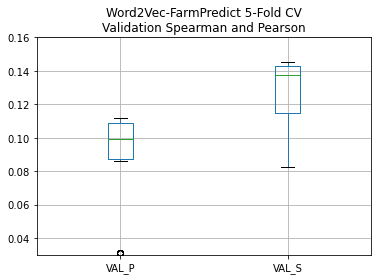

In [42]:
cv_results_folds_mean[['VAL_P','VAL_S']].boxplot()
plt.title('Word2Vec-FarmPredict 5-Fold CV\nValidation Spearman and Pearson')
plt.ylim(0.03,0.16); plt.show()

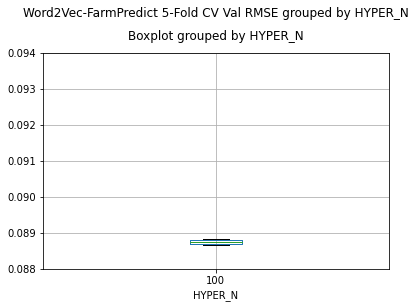

In [44]:
cv_results_folds_mean.boxplot(column='VAL_RMSE',by='HYPER_N',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val RMSE grouped by HYPER_N\n\n')
plt.ylim(0.088,0.094); plt.show()

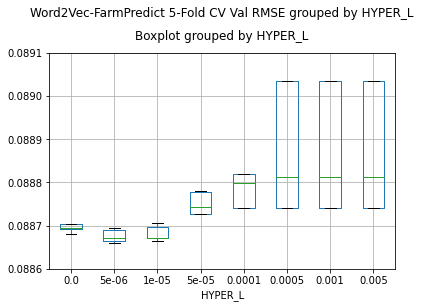

In [50]:
cv_results_folds_mean.boxplot(column='VAL_RMSE',by='HYPER_L',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val RMSE grouped by HYPER_L\n\n')
plt.ylim(0.0886,0.0891); plt.show()

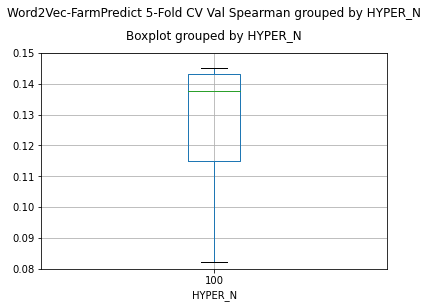

In [54]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_N',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val Spearman grouped by HYPER_N\n\n')
plt.ylim(0.08,0.15); plt.show()

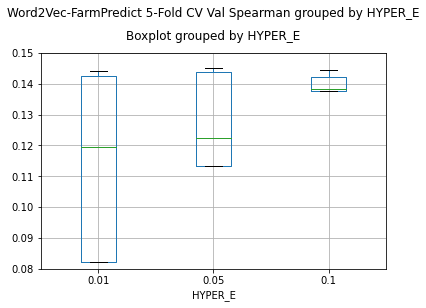

In [55]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_E',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val Spearman grouped by HYPER_E\n\n')
plt.ylim(0.08,0.15); plt.show()

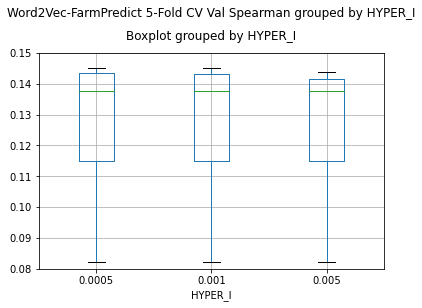

In [56]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_I',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val Spearman grouped by HYPER_I\n\n')
plt.ylim(0.08,0.15); plt.show()

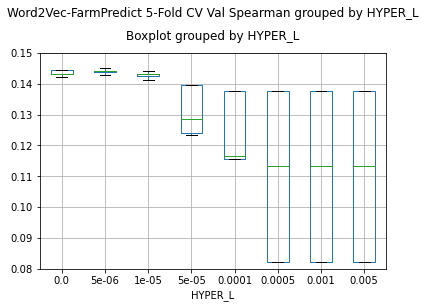

In [57]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_L',showfliers=False)
plt.title('Word2Vec-FarmPredict 5-Fold CV Val Spearman grouped by HYPER_L\n\n')
plt.ylim(0.08,0.15); plt.show()

### Testing

In [58]:
NUM_FEATURES = 100

EIGENVAL_PCT = 0.05
IDO_MIN_CORR = 0.0005
LASSO_LAMBDA = 0.000005

In [61]:
# store tensors on 1 (or 2) GPU devices (to aviod lack of memory)
DEVICE_1 = 'cuda:0'
DEVICE_2 = 'cuda:1'
    
columns = ['HYPER_N','HYPER_E','HYPER_I','HYPER_L','VAR_EXP','LEN_IDO',\
           'TRN_P','TRN_S','TRN_RMSE','VAL_P','VAL_S','VAL_RMSE']
    
print('Start Testing with Hyperparamters:\n{}\t{}\t{}\t{}'\
      .format(NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA))

data_train_t = data_train.copy(); data_test_t = data_test.copy()
    
# prepare tensors on GPU
X_train = torch.tensor(np.stack(data_train_t.word_vec.values)).type(torch.float32).cuda(device=DEVICE_1)
y_train = torch.tensor(np.array(data_train_t.specret_2d)).type(torch.float32).cuda(device=DEVICE_1)
X_test = torch.tensor(np.stack(data_test_t.word_vec.values)).type(torch.float32).cuda(device=DEVICE_2)
y_test = torch.tensor(np.array(data_test_t.specret_2d)).type(torch.float32).cuda(device=DEVICE_2)

# compute eigens of XTX
eigenvals_xtx, eigenvecs_xtx = torch.eig((X_train.T@X_train).cpu(), eigenvectors=True)

num_eigenval = int(NUM_FEATURES*(EIGENVAL_PCT))

# extract largest k real eigenvalues and their eigenvectors (of XXT)
eigenvals_real = extract_real(eigenvals_xtx)
eigenvals_df = pd.Series(eigenvals_real).sort_values(ascending=False)
variance_explained = eigenvals_df[:num_eigenval].sum()/eigenvals_df.sum()
eigenvals_topk = torch.topk(eigenvals_real,num_eigenval).indices
XV = torch.nn.functional.normalize((X_train@eigenvecs_xtx.cuda(device=DEVICE_1)).T,p=2).T[:,eigenvals_topk]

# compute/construct F_hat, B_hat, U_hat, BTB, and BTB inverse
F_hat = XV*(X_train.shape[0])**0.5
B_hat = X_train.T@F_hat.cuda(device=DEVICE_1)/(X_train.shape[0])
U_hat = X_train - F_hat@B_hat.T
BTB = torch.tensor(np.diag(torch.topk(extract_real(eigenvals_xtx),num_eigenval).values))/len(X_train)
BTB_inv = torch.linalg.inv(BTB).cuda(device=DEVICE_1)

# compute f_new and u_new for train and test data
f_new_train = (BTB_inv@B_hat.T)@X_train.T.type(torch.float32)
f_new_test = (BTB_inv.cuda(device=DEVICE_2)@B_hat.cuda(device=DEVICE_2).T)@X_test.T.type(torch.float32)
u_new_train = X_train.T - B_hat@f_new_train
u_new_test = X_test.T - B_hat.cuda(device=DEVICE_2)@f_new_test.cuda(device=DEVICE_2)

# OLS regression
reg1 = LinearRegression().fit(F_hat.cpu(), y_train.cpu())
y_hat = reg1.predict(F_hat.cpu())
a_hat = reg1.intercept_; b_hat = torch.tensor(reg1.coef_).cuda(device=DEVICE_1)
y_residual = y_train - torch.tensor(y_hat).cuda(device=DEVICE_1)

# correlation between U_hat and label
corrs = [pearsonr(U_hat.T[j].cpu(), y_train.cpu())[0] for j in range(len(U_hat.T))]
corrs = [0 if x != x else abs(x) for x in corrs]

df = pd.DataFrame(corrs,columns=['corr'])
df['isCharged'] = df['corr'].map(lambda x: abs(x)>IDO_MIN_CORR)
charged_index = list(df[df.isCharged].index)
U_hat_S_hat = U_hat.T[charged_index].T

# LASSO regression
reg2 = Lasso(alpha=LASSO_LAMBDA)
reg2.fit(U_hat_S_hat.cpu(),y_residual.cpu())
beta_hat = torch.tensor(reg2.coef_).cuda(device=DEVICE_1)
beta_nonzero_len = torch.count_nonzero(beta_hat)

Start Testing with Hyperparamters:
100	0.05	0.0005	5e-06


In [62]:
# testing
y_pred_train = a_hat + b_hat@f_new_train \
+ beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]
y_pred_train_sys = b_hat@f_new_train
y_pred_train_ido = beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]

y_pred_test = a_hat + b_hat.cuda(device=DEVICE_2)@f_new_test \
+ beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_test.type(torch.float32)[charged_index]
y_pred_test_sys = b_hat.cuda(device=DEVICE_2)@f_new_test
y_pred_test_ido = beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_test.type(torch.float32)[charged_index]

train_pearson = round(pearsonr(y_train.cpu(),y_pred_train.cpu())[0],6)
train_spearman = round(spearmanr(y_train.cpu(),y_pred_train.cpu())[0],6)
train_rmse = round((((np.array(y_train.cpu()) - np.array(y_pred_train.cpu()))**2).mean())**0.5,6)

test_pearson = round(pearsonr(y_test.cpu(),y_pred_test.cpu())[0],6)
test_spearman = round(spearmanr(y_test.cpu(),y_pred_test.cpu())[0],6)
test_rmse = round(float(((np.array(y_test.cpu()) - np.array(y_pred_test.cpu())**2).mean())**0.5),6)

SPECS = (NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA)
stats = (round(variance_explained,6),str(int(beta_nonzero_len))+'/'+str(len(charged_index)))
performance = (train_pearson,train_spearman,train_rmse,test_pearson,test_spearman,test_rmse)
test_summary_df = pd.DataFrame([[*SPECS,*stats,*performance]],columns=columns)
                
clear_output()
test_summary_df

,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
0,100,0.05,0.0005,0.000005,0.963517,60/94,0.085464,0.147207,0.099467,0.089585,0.098148,0.091378


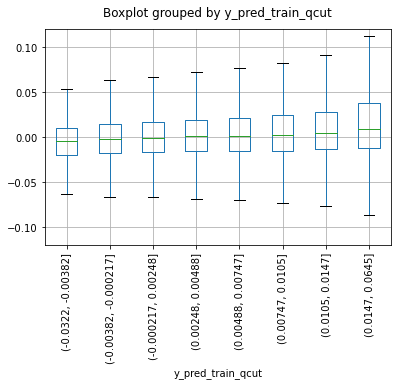

In [63]:
bp_df = pd.DataFrame(np.hstack((np.array(y_train.cpu()).reshape(-1,1),np.array(y_pred_train.cpu()).reshape(-1,1))),\
                     columns=['y_train','y_pred_train'])
bp_df['y_pred_train_qcut'] = pd.qcut(y_pred_train.cpu(),q=8)
bp_df.boxplot(column=['y_train'], by='y_pred_train_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

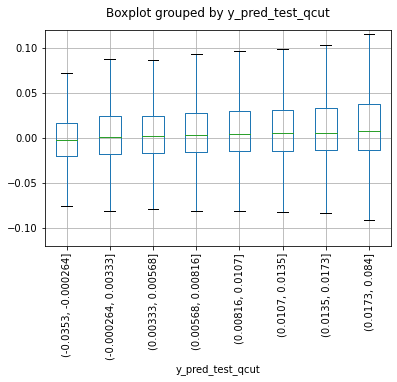

In [64]:
bp_df = pd.DataFrame(np.hstack((np.array(y_test.cpu()).reshape(-1,1),np.array(y_pred_test.cpu()).reshape(-1,1))),\
                     columns=['y_test','y_pred_test'])
bp_df['y_pred_test_qcut'] = pd.qcut(y_pred_test.cpu(),q=8)
bp_df.boxplot(column=['y_test'], by='y_pred_test_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

In [65]:
test_results = data_test[['ID','SecuCode','date','specret_2d']]
test_results['y_pred'] = y_pred_test.cpu()
test_results['y_pred_sys'] = y_pred_test_sys.cpu()
test_results['y_pred_ido'] = y_pred_test_ido.cpu()

In [66]:
test_results.head(3)

,ID,SecuCode,date,specret_2d,y_pred,y_pred_sys,y_pred_ido
180353,672010,600315,2015-01-05,0.044812,0.008884,-0.001634,0.006616
180354,672047,600315,2015-01-05,0.044812,0.006446,0.003222,-0.000678
180355,672017,000063,2015-01-05,0.066843,0.001845,0.010723,-0.012780


In [67]:
serial

'20220420_tencent'

In [69]:
test_results.to_parquet(OUTPUT_PATH+'test_results_FarmPredict_GS-tuned_{}.parquet.gzip'.format(serial))

In [86]:
test_results[['specret_2d','y_pred','y_pred_sys','y_pred_ido']].corr(method='spearman')

,specret_2d,y_pred,y_pred_sys,y_pred_ido
specret_2d,1.000000,0.098148,0.062008,0.083657
y_pred,0.098148,1.000000,0.792090,0.614517
y_pred_sys,0.062008,0.792090,1.000000,0.051709
y_pred_ido,0.083657,0.614517,0.051709,1.000000


### Compare with FarmPredict

In [74]:
farm_test_results = pd.read_parquet('./output/test_results_FarmPredict_GS-tuned_20220420_full.parquet.gzip')

In [81]:
merged = farm_test_results.merge(test_results\
                        .rename(columns={'y_pred':'w2v_y_pred','y_pred_sys':'w2v_y_pred_sys','y_pred_ido':'w2v_y_pred_ido'}),\
                        on=['ID', 'SecuCode', 'date', 'specret_2d'])

In [84]:
merged[['specret_2d','y_pred','y_pred_sys','y_pred_ido','w2v_y_pred','w2v_y_pred_sys','w2v_y_pred_ido']]\
.corr(method='spearman')

,specret_2d,y_pred,y_pred_sys,y_pred_ido,w2v_y_pred,w2v_y_pred_sys,w2v_y_pred_ido
specret_2d,1.000000,0.116604,0.118163,-0.007696,0.098404,0.059815,0.084630
y_pred,0.116604,1.000000,0.981207,-0.149254,0.721859,0.563906,0.462593
y_pred_sys,0.118163,0.981207,1.000000,-0.258330,0.730404,0.568655,0.470155
y_pred_ido,-0.007696,-0.149254,-0.258330,1.000000,-0.240178,-0.213300,-0.126411
w2v_y_pred,0.098404,0.721859,0.730404,-0.240178,1.000000,0.785381,0.613710
w2v_y_pred_sys,0.059815,0.563906,0.568655,-0.213300,0.785381,1.000000,0.040873
w2v_y_pred_ido,0.084630,0.462593,0.470155,-0.126411,0.613710,0.040873,1.000000


In [87]:
merged

,ID,SecuCode,date,specret_2d,y_pred,y_pred_sys,y_pred_ido,w2v_y_pred,w2v_y_pred_sys,w2v_y_pred_ido
0,672010,600315,2015-01-05,0.044812,0.013484,0.008724,-0.000414,0.008884,-0.001634,0.006616
1,672047,600315,2015-01-05,0.044812,0.005509,-0.003976,0.004311,0.006446,0.003222,-0.000678
2,672017,000063,2015-01-05,0.066843,0.008303,0.002951,0.000179,0.001845,0.010723,-0.012780
3,672322,000063,2015-01-05,0.066843,0.007537,0.002234,0.000129,0.015670,0.012363,-0.000596
4,672021,601628,2015-01-05,-0.046523,0.016169,0.010439,0.000557,0.015113,0.002325,0.008886
...,...,...,...,...,...,...,...,...,...,...
316625,1387639,000887,2021-07-12,0.048077,0.013318,0.008220,-0.000076,0.007024,0.005648,-0.002526
316626,1387640,002508,2021-07-21,-0.051396,0.006364,0.001210,-0.000019,0.008901,0.001329,0.003670
316627,1387641,002555,2021-06-30,-0.007810,0.010921,0.005797,-0.000050,0.019836,0.004752,0.011182
316628,1387645,300623,2021-07-09,0.010063,0.008674,0.003388,0.000112,0.015885,0.006398,0.005585


In [90]:
merged.to_parquet(OUTPUT_PATH+'test_results_FarmPredict_W2V-FP_GS-tuned_20220420_full_w2v-tencent.parquet.gzip')